In [1]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from copy import deepcopy

import orbit
from orbit.models.template import BaseTemplate
from orbit.models.template import FullBayesianTemplate
from orbit.estimators.pyro_estimator import PyroEstimatorVI

from orbit.utils.simulation import make_regression
from orbit.diagnostics.plot import plot_predicted_data
%matplotlib inline

In [2]:
import orbit
print(orbit.__version__)

1.0.14dev


In [3]:
import numpy as np
import pandas as pd

from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP
from orbit.models.lm import LinearModelFull, LinearModelMAP

from orbit.utils.simulation import make_regression
from orbit.diagnostics.plot import plot_predicted_data
%matplotlib inline

Prepare the input data.

In [4]:
x, y, coefs = make_regression(120, [3.0, -1.0], bias=1.0, scale=1.0)

In [5]:
df = pd.DataFrame(
    np.concatenate([y.reshape(-1, 1), x], axis=1), columns=['y', 'x1', 'x2']
)
df['week'] = pd.date_range(start='2016-01-04', periods=len(y), freq='7D')

In [6]:
df.head(5)

,y,x1,x2,week
0,2.382337,0.345584,0.000000,2016-01-04
1,2.812929,0.330437,-0.000000,2016-01-11
2,3.600130,0.905356,0.446375,2016-01-18
3,-0.884275,-0.000000,0.581118,2016-01-25
4,2.704941,0.364572,0.294132,2016-02-01


In [7]:
test_size = 20
train_df = df[:-test_size]
test_df = df[-test_size:]

Instantiate the new model object.

In [8]:
mod_full = LinearModelFull(
    response_col='y', 
    date_col='week',
    regressor_col=['x1','x2'], 
    verbose=True,
    seed=2021,
)

mod_map = LinearModelMAP(
    response_col='y', 
    date_col='week',
    regressor_col=['x1','x2'], 
    verbose=True,
    seed=2021,
)

INFO:root:Using 4 chains, 4 cores, 225 warmup and 25 samples per chain for sampling.
INFO:root:Using 4 chains, 4 cores, 225 warmup and 25 samples per chain for sampling.


In [9]:
mod_full.fit(df=train_df)
mod_map.fit(df=train_df)

In [11]:
estimated_weights_full = mod_full._posterior_samples['beta']
estimated_weights_map = mod_map._posterior_samples['beta']

In [16]:
print("True Coef: {:.3f}, {:.3f}".format(coefs[0], coefs[1]) )
estimated_coef_full = np.median(estimated_weights_full, axis=0)
print("Median of Estimated Coef LinearModelFULL: {:.3f}, {:.3f}".format(estimated_coef_full[0], estimated_coef_full[1]))
estimated_coef_map = estimated_weights_map
print("Estimated Coef LinearModelMAP: {:.3f}, {:.3f}".format(estimated_coef_map[0], estimated_coef_map[1]))

True Coef: 3.000, -1.000
Median of Estimated Coef LinearModelFULL: 2.944, -0.950
Estimated Coef LinearModelMAP: 2.948, -0.972


In [17]:
predicted_df_full = mod_full.predict(df)
predicted_df_map = mod_map.predict(df)

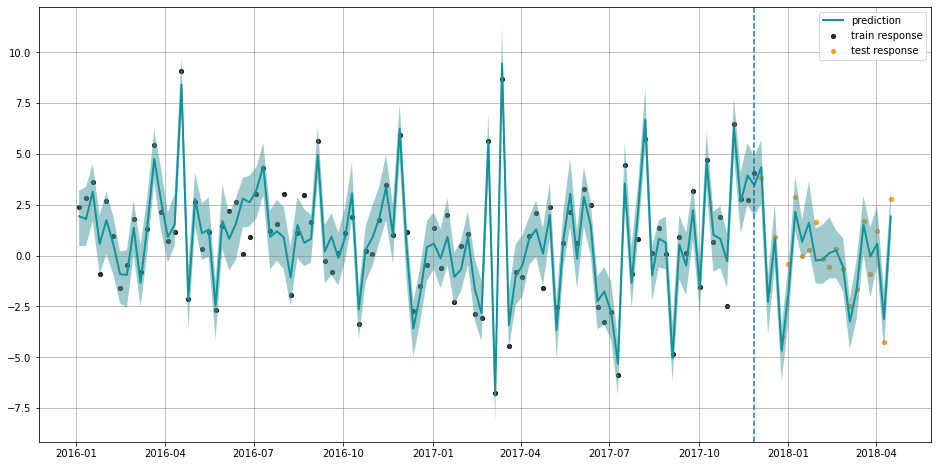

In [19]:
_ = plot_predicted_data(train_df, predicted_df_full, 'week', 'y', test_actual_df=test_df, prediction_percentiles=[5, 95])

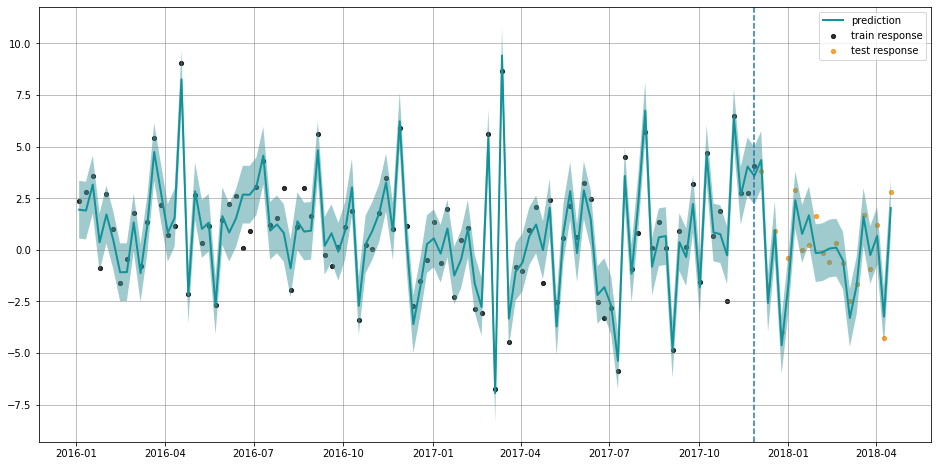

In [20]:
_ = plot_predicted_data(train_df, predicted_df_map, 'week', 'y', test_actual_df=test_df, prediction_percentiles=[5, 95])